In [78]:
#pip install keras-tuner

  Obtaining dependency information for keras-tuner from https://files.pythonhosted.org/packages/db/5d/945296512980b0827e93418514c8be9236baa6f0a1e8ca8be3a2026665b0/keras_tuner-1.4.7-py3-none-any.whl.metadata
  Obtaining dependency information for kt-legacy from https://files.pythonhosted.org/packages/16/53/aca9f36da2516db008017db85a1f3cafaee0efc5fc7a25d94c909651792f/kt_legacy-1.0.5-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 886.7 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dense, Dropout, BatchNormalization

# 讀取 Excel 表
df1 = pd.read_excel('/Users/ccit0915/Desktop/論文素材/論文data彙整1130413.xlsx', sheet_name='2024-1月')
df2 = pd.read_excel('/Users/ccit0915/Desktop/論文素材/論文data彙整1130413.xlsx', sheet_name='2024-2月')
df3 = pd.read_excel('/Users/ccit0915/Desktop/論文素材/論文data彙整1130413.xlsx', sheet_name='2024-3月')
df4 = pd.read_excel('/Users/ccit0915/Desktop/論文素材/論文data彙整1130413.xlsx', sheet_name='2024-4月')
df5 = pd.read_excel('/Users/ccit0915/Desktop/論文素材/論文data彙整1130413.xlsx', sheet_name='2024-5月')
df6 = pd.read_excel('/Users/ccit0915/Desktop/論文素材/論文data彙整1130413.xlsx', sheet_name='2024-6月')

# 合併 DataFrame
df = pd.concat([df1, df2, df3, df4, df5, df6], ignore_index=True)

# 顯示合併後的 DataFrame
print(df.head())

               原料編號      產品編號   數量       下料日期  單片排版數   PCS總數 客戶名稱
0  1BT-30M10PZZ152D  7P05-N72  144 2024-01-02    600   86400  P05
1  1BT-30M10PZZ152D  7P05-N90  384 2024-01-02    880  337920  P05
2  1BT-44N10PZZ182L  7A66-DD7   48 2024-01-02   1280   61440  A66
3  1BT-44N10PZZ182L  7A67-J03   96 2024-01-02   2750  264000  A67
4  1BT-44N10PZZ182L  7A67-J27   48 2024-01-02   1350   64800  A67


In [9]:
# 找出稀少類別的函數
def find_rare_categories(df, columns):
    rare_categories = {}
    for column in columns:
        counts = df[column].value_counts()
        rare = counts[counts == 1].index.tolist()  # 篩選只出現一次的類別
        if rare:
            rare_categories[column] = rare
    return rare_categories

# 找出稀少類別
columns_to_check = ['原料編號', '客戶名稱']
rare_categories = find_rare_categories(df, columns_to_check)

# 刪除包含稀少類別的行數
for column, rare in rare_categories.items():
    df = df[~df[column].isin(rare)]  # 用 ~ 排除稀少類別的行數

# 顯示刪除後的 DataFrame
print(df)

# 檢查刪除情況
for column, rare in rare_categories.items():
    print(f"刪除的稀少類別 ({column}): {rare}")

                  原料編號      產品編號   數量       下料日期  單片排版數   PCS總數 客戶名稱
0     1BT-30M10PZZ152D  7P05-N72  144 2024-01-02    600   86400  P05
1     1BT-30M10PZZ152D  7P05-N90  384 2024-01-02    880  337920  P05
2     1BT-44N10PZZ182L  7A66-DD7   48 2024-01-02   1280   61440  A66
3     1BT-44N10PZZ182L  7A67-J03   96 2024-01-02   2750  264000  A67
4     1BT-44N10PZZ182L  7A67-J27   48 2024-01-02   1350   64800  A67
...                ...       ...  ...        ...    ...     ...  ...
2785  1BT-43N10PZZ112L  7Q51-642   60 2024-06-30   1120   67200  A66
2786  1BT-43N10PZZ112L  7Q56-452  180 2024-06-30   1680  302400  L08
2787  1BT-43N10PZZ112L  7Q51-452   40 2024-06-30   1680   67200  A66
2788  1BT-62A06P32252M  7Q52-707   96 2024-06-30   3456  331776  P01
2789  1BT-62J04P32252M  7S20-754  192 2024-06-30    600  115200  S20

[2786 rows x 7 columns]
刪除的稀少類別 (原料編號): ['1BT-33J0KP32252D', '1BT-66T05P32212M']
刪除的稀少類別 (客戶名稱): ['P03', 'T80']


In [11]:
df.drop(columns=['單片排版數', '數量'], inplace=True)
print(df.head())

               原料編號      產品編號       下料日期   PCS總數 客戶名稱
0  1BT-30M10PZZ152D  7P05-N72 2024-01-02   86400  P05
1  1BT-30M10PZZ152D  7P05-N90 2024-01-02  337920  P05
2  1BT-44N10PZZ182L  7A66-DD7 2024-01-02   61440  A66
3  1BT-44N10PZZ182L  7A67-J03 2024-01-02  264000  A67
4  1BT-44N10PZZ182L  7A67-J27 2024-01-02   64800  A67


In [13]:
# 對'PCS總數' 進行對數轉換
df['PCS總數'] = df['PCS總數'].apply(lambda x: np.log(x))

print(df.head())

               原料編號      產品編號       下料日期      PCS總數 客戶名稱
0  1BT-30M10PZZ152D  7P05-N72 2024-01-02  11.366743  P05
1  1BT-30M10PZZ152D  7P05-N90 2024-01-02  12.730564  P05
2  1BT-44N10PZZ182L  7A66-DD7 2024-01-02  11.025816  A66
3  1BT-44N10PZZ182L  7A67-J03 2024-01-02  12.483704  A67
4  1BT-44N10PZZ182L  7A67-J27 2024-01-02  11.079061  A67


In [15]:
# 先將 '下料日期' 欄位轉換為日期時間格式
df['下料日期'] = pd.to_datetime(df['下料日期'])

# 提取年、月、日特徵
df['year'] = df['下料日期'].dt.year
df['mon'] = df['下料日期'].dt.month
df['day'] = df['下料日期'].dt.day

# 新增季度欄位
#def get_quarter(month):
    #if month in [1, 2, 3]:
        #return 1
    #elif month in [4, 5, 6]:
        #return 2
    #elif month in [7, 8, 9]:
        #return 3
    #else:
        #return 4

#df['季度'] = df['月'].apply(get_quarter)

In [17]:
df

,原料編號,產品編號,下料日期,PCS總數,客戶名稱,year,mon,day
0,1BT-30M10PZZ152D,7P05-N72,2024-01-02,11.366743,P05,2024,1,2
1,1BT-30M10PZZ152D,7P05-N90,2024-01-02,12.730564,P05,2024,1,2
2,1BT-44N10PZZ182L,7A66-DD7,2024-01-02,11.025816,A66,2024,1,2
3,1BT-44N10PZZ182L,7A67-J03,2024-01-02,12.483704,A67,2024,1,2
4,1BT-44N10PZZ182L,7A67-J27,2024-01-02,11.079061,A67,2024,1,2
...,...,...,...,...,...,...,...,...
2785,1BT-43N10PZZ112L,7Q51-642,2024-06-30,11.115429,A66,2024,6,30
2786,1BT-43N10PZZ112L,7Q56-452,2024-06-30,12.619506,L08,2024,6,30
2787,1BT-43N10PZZ112L,7Q51-452,2024-06-30,11.115429,A66,2024,6,30
2788,1BT-62A06P32252M,7Q52-707,2024-06-30,12.712215,P01,2024,6,30


In [19]:
from sklearn.model_selection import train_test_split

# 定義特徵 (X) 和目標變數 (y)
X = df[['產品編號', 'mon', 'day', '客戶名稱', '原料編號']]  # 特徵
y = df['PCS總數']  # 目標變數


# 將數據分成訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(2228, 5)
(558, 5)


In [21]:
import category_encoders as ce

# 創建目標編碼器
target_encoder_train = ce.TargetEncoder(cols=['產品編號'])
X_train['product_encoded'] = target_encoder_train.fit_transform(X_train['產品編號'], y_train)

# 計算 '客戶名稱' 的頻率
customer_freq_train = X_train['客戶名稱'].value_counts(normalize=True)
X_train['client_encoded'] = X_train['客戶名稱'].map(customer_freq_train)

# 計算 '原料編號' 的頻率
material_freq_train = X_train['原料編號'].value_counts(normalize=True)
X_train['raw_material_encoded'] = X_train['原料編號'].map(material_freq_train)

In [23]:
# 將 y_train（PCS總數）臨時加入 X_train
X_train['PCS總數'] = y_train

# 計算新特徵
X_train['product_raw_material_interaction_encoded'] = X_train.groupby(['product_encoded', 'raw_material_encoded'])['PCS總數'].transform('mean')
X_train['product_client_interaction_encoded'] = X_train.groupby(['product_encoded', 'client_encoded'])['PCS總數'].transform('mean')
X_train['product_mon'] =  X_train['product_encoded'] * X_train['mon']
X_train['product_day'] =  X_train['product_encoded'] * X_train['day']

# 計算完後，可以選擇再次移除
X_train.drop(columns=['PCS總數'], inplace=True)

In [25]:
X_train.drop(columns=['原料編號'], inplace=True)
X_train.drop(columns=['客戶名稱'], inplace=True)
X_train.drop(columns=['產品編號'], inplace=True)

X_train

,mon,day,product_encoded,client_encoded,raw_material_encoded,product_raw_material_interaction_encoded,product_client_interaction_encoded,product_mon,product_day
600,2,7,9.527831,0.125224,0.109515,9.496365,9.496365,19.055663,66.694819
1520,4,13,11.714130,0.179533,0.087971,13.432364,13.432364,46.856521,152.283694
2750,6,27,12.532385,0.039946,0.035907,13.110459,13.110459,75.194308,338.374388
100,1,9,11.095987,0.038151,0.030521,10.488235,10.488235,11.095987,99.863884
316,1,22,11.246378,0.054309,0.092460,11.248960,11.248960,11.246378,247.420319
...,...,...,...,...,...,...,...,...,...
1640,4,20,11.272734,0.179533,0.215440,11.278160,11.278160,45.090935,225.454674
1096,3,11,11.601024,0.074057,0.015709,12.027154,11.967648,34.803072,127.611263
1131,3,14,9.769504,0.125224,0.109515,9.702995,9.702995,29.308512,136.773055
1296,3,25,11.336035,0.003142,0.021095,11.782691,11.782691,34.008105,283.400878


In [27]:
import category_encoders as ce

# 用訓練集的 target_encoder 來轉換測試集
X_test['product_encoded'] = target_encoder_train.transform(X_test['產品編號'])

# 用訓練集的頻率來轉換測試集
X_test['client_encoded'] = X_test['客戶名稱'].map(customer_freq_train)
X_test['raw_material_encoded'] = X_test['原料編號'].map(material_freq_train)

In [29]:
# 將 y_test（PCS總數）臨時加入 X_test
X_test['PCS總數'] = y_test

# 計算新特徵
X_test['product_raw_material_interaction_encoded'] = X_test.groupby(['product_encoded', 'raw_material_encoded'])['PCS總數'].transform('mean')
X_test['product_client_interaction_encoded'] = X_test.groupby(['product_encoded', 'client_encoded'])['PCS總數'].transform('mean')
X_test['product_mon'] =  X_test['product_encoded'] * X_test['mon']
X_test['product_day'] =  X_test['product_encoded'] * X_test['day']

# 計算完後，可以選擇再次移除
X_test.drop(columns=['PCS總數'], inplace=True)

In [31]:
X_test.drop(columns=['原料編號'], inplace=True)
X_test.drop(columns=['客戶名稱'], inplace=True)
X_test.drop(columns=['產品編號'], inplace=True)

X_test

,mon,day,product_encoded,client_encoded,raw_material_encoded,product_raw_material_interaction_encoded,product_client_interaction_encoded,product_mon,product_day
2081,5,24,11.279278,0.060592,0.215440,11.212639,11.212639,56.396389,270.702667
2774,6,29,13.102202,0.018402,0.035907,13.365721,13.365721,78.613211,379.963852
1467,4,9,12.188240,0.074057,0.031418,12.588150,12.588150,48.752961,109.694162
2092,5,25,11.010408,0.143178,0.117145,11.281384,11.281384,55.052038,275.260189
2121,5,26,11.614863,0.054309,0.027828,11.789580,11.789580,58.074316,301.986445
...,...,...,...,...,...,...,...,...,...
1437,4,5,12.532385,0.039946,0.035907,12.848434,12.848434,50.129539,62.661924
157,1,14,11.537241,0.039946,0.025583,12.445684,12.445684,11.537241,161.521376
1661,4,22,12.111258,0.179533,0.035907,13.017476,13.017476,48.445032,266.447675
1458,4,9,11.406051,0.078097,0.013016,11.857158,11.857158,45.624205,102.654462


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras_tuner import HyperModel, RandomSearch
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.optimizers import Adam, Adamax


class RegressionHyperModel(HyperModel):
    def build(self, hp):
        model = Sequential()
        units1 = hp.Int('units1', min_value=50, max_value=200, step=50)
        units2 = hp.Int('units2', min_value=50, max_value=200, step=50)
        model.add(Dense(units1, activation='elu', input_dim=X_train_scaled.shape[1]))
        model.add(Dense(units2, activation='elu'))
        model.add(Dense(1))
        
        optimizer = hp.Choice('optimizer', values=['adam', 'adamax'])
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        return model

In [35]:
# 准备数据
X = X_train[['product_encoded', 'client_encoded', 'mon', 'day', 'raw_material_encoded', 'product_raw_material_interaction_encoded', 
            'product_client_interaction_encoded','product_mon', 'product_day' ]]
y = y_train

# 数据分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 标准化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 实例化调优器
tuner = RandomSearch(
    RegressionHyperModel(),
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# 执行调优
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, batch_size=32)

# 获取最佳超参数
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

# 打印所有超参数
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

for key, value in best_hyperparameters.values.items():
    print(f"{key}: {value}")

# 打印特定超参数（如果已知）
print(f"Units in first layer: {best_hyperparameters.get('units')}")
print(f"Optimizer: {best_hyperparameters.get('optimizer')}")

Reloading Tuner from my_dir/helloworld/tuner0.json
units: 150
optimizer: adam
Units in first layer: 150
Optimizer: adam


In [37]:
# 定义最佳超参数
units1 = 150  # 从网格搜索结果中获得
units2 = 100   # 从网格搜索结果中获得
optimizer_name = 'adam'  # 从网格搜索结果中获得

# 选择优化器
if optimizer_name == 'adam':
    optimizer = Adam()
elif optimizer_name == 'adamax':
    optimizer = Adamax()

# 建构模型
model = Sequential()
model.add(Dense(units1, input_dim=X_train_scaled.shape[1], activation='elu', kernel_regularizer='l2'))
model.add(Dense(units2, activation='elu'))
model.add(Dense(1))

# 编译模型
model.compile(optimizer=optimizer, loss='mse')

# 进行训练
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 预测 PCS 总数
y_pred = model.predict(X_test_scaled)

# PCS 总数转换回原始值（如果进行了转换）
# y_pred_original = np.exp(y_pred)  # 如果预测值进行了对数变换

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}")
print(f"R2 Score: {r2}")

Epoch 1/50
45/45 [==============================] - 0s 2ms/step - loss: 94.7735 - val_loss: 44.5541
Epoch 2/50
45/45 [==============================] - 0s 837us/step - loss: 14.0317 - val_loss: 4.4096
Epoch 3/50
45/45 [==============================] - 0s 811us/step - loss: 3.0303 - val_loss: 2.2414
Epoch 4/50
45/45 [==============================] - 0s 808us/step - loss: 1.8550 - val_loss: 1.5243
Epoch 5/50
45/45 [==============================] - 0s 814us/step - loss: 1.3559 - val_loss: 1.2131
Epoch 6/50
45/45 [==============================] - 0s 817us/step - loss: 1.1068 - val_loss: 1.0064
Epoch 7/50
45/45 [==============================] - 0s 831us/step - loss: 0.9514 - val_loss: 0.9068
Epoch 8/50
45/45 [==============================] - 0s 807us/step - loss: 0.8539 - val_loss: 0.8150
Epoch 9/50
45/45 [==============================] - 0s 786us/step - loss: 0.7689 - val_loss: 0.7020
Epoch 10/50
45/45 [==============================] - 0s 828us/step - loss: 0.7064 - val_loss: 0.677

In [39]:
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# 计算 R² 分数
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Train R^2 Score :", train_r2)
print("Test R^2 Score :", test_r2)

14/14 [==============================] - 0s 386us/step
Train R^2 Score : 0.8333988767590772
Test R^2 Score : 0.7972720709705445


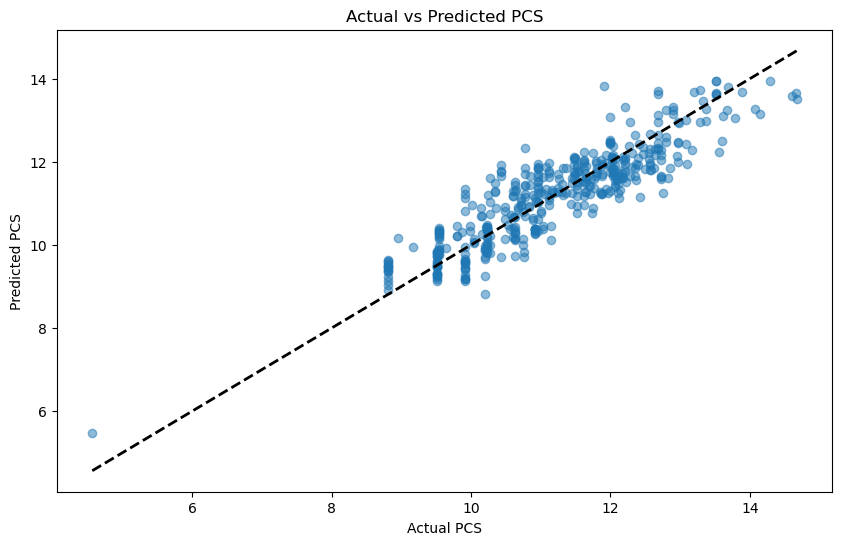

In [41]:
import matplotlib.pyplot as plt

def visualize_results(y_test, y_pred):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual PCS')
    plt.ylabel('Predicted PCS')
    plt.title('Actual vs Predicted PCS')
    plt.show()

# 使用示例
visualize_results(y_test, y_pred)

In [43]:
from sklearn.metrics import mean_absolute_error

# 计算训练集上的预测值
y_train_pred = model.predict(X_train_scaled)

# 计算训练集和测试集上的评估指标
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_pred)

# 输出评估指标
print(f"Train MAE: {train_mae}")
print(f"Test MAE: {test_mae}")
print(f"Train MSE: {train_mse}")
print(f"Test MSE: {test_mse}")
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")
print(f"Train R^2 Score: {train_r2}")
print(f"Test R^2 Score: {test_r2}")


56/56 [==============================] - 0s 483us/step
Train MAE: 0.4433019313139387
Test MAE: 0.4588866653984612
Train MSE: 0.3087604377828978
Test MSE: 0.3212005634188457
Train RMSE: 0.5556621615540308
Test RMSE: 0.5667455896774546
Train R^2 Score: 0.8333988767590772
Test R^2 Score: 0.7972720709705445


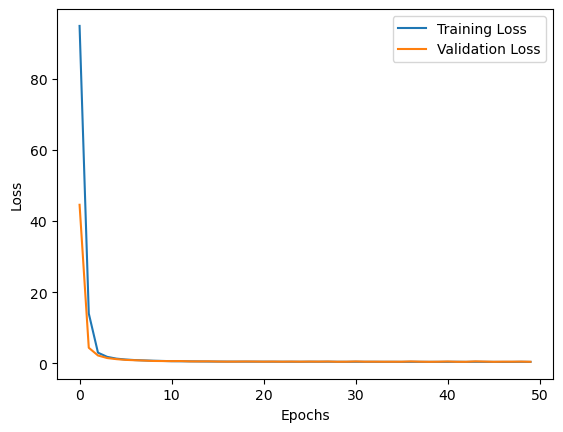

In [45]:
import matplotlib.pyplot as plt

# 绘制训练和验证损失
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

def calculate_vif(X):
    """
    计算特征的VIF值
    
    参数：
    X : DataFrame，包含所有特征的数据集
    
    返回：
    vif : Series，包含每个特征的VIF值
    """
    # 添加常数项
    X_with_const = add_constant(X)
    # 计算VIF值
    vif = pd.Series([variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])], index=X_with_const.columns)
    return vif

# 使用示例
vif_values = calculate_vif(X)
print(vif_values)

const                                       1456.812611
product_encoded                               12.153994
client_encoded                                 1.158497
mon                                          181.373152
day                                          171.526614
raw_material_encoded                           1.143432
product_raw_material_interaction_encoded     526.527783
product_client_interaction_encoded           526.669883
product_mon                                  187.877677
product_day                                  176.432640
dtype: float64


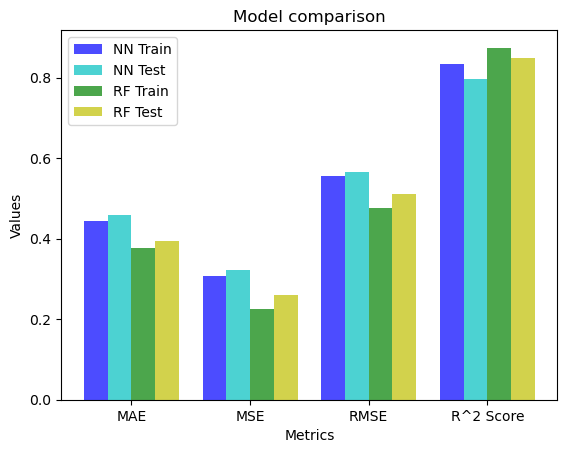

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# 定義四個性能指標
metrics = ['MAE', 'MSE', 'RMSE', 'R^2 Score']

# 神經網路的性能指標（更新後）
nn_train = [0.443, 0.308, 0.555, 0.833]
nn_test = [0.458, 0.321, 0.566, 0.797]

# 隨機森林回歸器的性能指標（更新後）
rf_train = [0.376, 0.225, 0.475, 0.874]
rf_test = [0.393, 0.260, 0.510, 0.849]

# 設定柱狀圖的寬度
bar_width = 0.2

# 設定圖表的位置
index = np.arange(len(metrics))

# 繪製神經網路的性能指標柱狀圖
plt.bar(index - 1.5 * bar_width, nn_train, bar_width, label='NN Train', alpha=0.7, color='b')
plt.bar(index - 0.5 * bar_width, nn_test, bar_width, label='NN Test', alpha=0.7, color='c')

# 繪製隨機森林回歸器的性能指標柱狀圖
plt.bar(index + 0.5 * bar_width, rf_train, bar_width, label='RF Train', alpha=0.7, color='g')
plt.bar(index + 1.5 * bar_width, rf_test, bar_width, label='RF Test', alpha=0.7, color='y')

# 設定圖表標題和標籤
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model comparison')
plt.xticks(index, metrics)

# 顯示圖例
plt.legend()

# 顯示圖表
plt.show()